In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

In [2]:
import pandas as pd

data = pd.read_csv('datasets/df_f_new.csv')

# Mezclar todas las filas
data_shuffled = data.sample(frac=1).reset_index(drop=True)

data_shuffled

,Image,Category
0,green-glass/green-glass487.jpg,4
1,metal/metal378.jpg,5
2,metal/metal743.jpg,5
3,metal/metal342.jpg,5
4,trash/trash277.jpg,8
...,...,...
8208,white-glass/white-glass637.jpg,9
8209,white-glass/white-glass47.jpg,9
8210,battery/battery553.jpg,0
8211,biological/biological535.jpg,1


In [3]:
def split_data(data_shuffled,ratio):
    last=int(len(data_shuffled)*ratio)
    return data[:last], data[last:]

In [4]:
data_shuffled['Category'].value_counts()

Category
6    1050
1     985
0     945
3     891
7     865
9     775
5     769
8     697
4     629
2     607
Name: count, dtype: int64

In [8]:
import numpy as np

def split_data(data_shuffled, train_ratio):
    # Obtener las categorías únicas en los datos
    unique_categories = np.unique(data_shuffled['Category'])

    # Dividir los datos en conjunto de entrenamiento y validación para cada categoría
    train_data = []
    valid_data = []
    for category in unique_categories:
        category_data = data_shuffled[data_shuffled['Category'] == category]
        train_size = int(len(category_data) * train_ratio)
        train_category = category_data[:train_size]
        valid_category = category_data[train_size:]
        train_data.append(train_category)
        valid_data.append(valid_category)

    # Combinar los datos de todas las categorías en un solo conjunto de entrenamiento y validación
    train = pd.concat(train_data)
    test = pd.concat(valid_data)

    return train, test


In [9]:
train, test = split_data(data_shuffled, 0.8)

In [11]:
test['Category'].value_counts()

Category
6    210
1    197
0    189
3    179
7    173
9    155
5    154
8    140
4    126
2    122
Name: count, dtype: int64

In [12]:
train.to_csv('train_kaggle.csv',index=False)
test.to_csv('test_kaggle.csv',index=False)

In [13]:
from sklearn.utils import resample

In [14]:
train['Category'].value_counts()

Category
6    840
1    788
0    756
3    712
7    692
9    620
5    615
8    557
4    503
2    485
Name: count, dtype: int64

In [16]:
train,valid=split_data(train,.9)

In [24]:
train

,Image,Category
21,battery/battery403.jpg,0
35,battery/battery182.jpg,0
38,battery/battery393.jpg,0
51,battery/battery464.jpg,0
66,battery/battery231.jpg,0
...,...,...
5828,white-glass/white-glass282.jpg,9
5837,white-glass/white-glass561.jpg,9
5878,white-glass/white-glass679.jpg,9
5889,white-glass/white-glass688.jpg,9


In [17]:
train["Category"].value_counts()

Category
6    756
1    709
0    680
3    640
7    622
9    558
5    553
8    501
4    452
2    436
Name: count, dtype: int64

In [18]:
valid["Category"].value_counts()

Category
6    84
1    79
0    76
3    72
7    70
5    62
9    62
8    56
4    51
2    49
Name: count, dtype: int64

In [31]:
valid

,Image,Category
5913,plastic/plastic132.jpg,7
5914,plastic/plastic133.jpg,7
5915,plastic/plastic134.jpg,7
5916,plastic/plastic135.jpg,7
5917,plastic/plastic136.jpg,7
...,...,...
8208,white-glass/white-glass95.jpg,9
8209,white-glass/white-glass96.jpg,9
8210,white-glass/white-glass97.jpg,9
8211,white-glass/white-glass98.jpg,9


In [19]:
test

,Image,Category
6617,battery/battery344.jpg,0
6620,battery/battery944.jpg,0
6644,battery/battery657.jpg,0
6645,battery/battery495.jpg,0
6646,battery/battery359.jpg,0
...,...,...
8204,white-glass/white-glass62.jpg,9
8205,white-glass/white-glass324.jpg,9
8207,white-glass/white-glass300.jpg,9
8208,white-glass/white-glass637.jpg,9


In [22]:
valid["Category"].value_counts()

Category
6    84
1    79
0    76
3    72
7    70
5    62
9    62
8    56
4    51
2    49
Name: count, dtype: int64

In [25]:
data_directory = "new_garbage_classification/"

In [26]:
batch_size = 16
size=224
epoch=50
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=data_directory, 
    x_col='Image',
    y_col='Category',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=valid,
    directory=data_directory, 
    x_col='Image',
    y_col='Category',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )

Found 5907 validated image filenames.
Found 661 validated image filenames.


In [27]:
def se_block_enc(inputs,alpha):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=alpha, activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [29]:
input_img = Input(shape=(size,size, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x=se_block_enc(x,20)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,30)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,50)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Bottolneck
latentSize = (28,28,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

In [40]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1344        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 48)          0           ['conv2d[0][0]']                 
 alAveragePooling2D)                                                                        

In [47]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
history = autoencoder.fit_generator(train_generator,validation_data= valid_generator,epochs = 1, verbose=2)

C:\Users\Leticia Martinez\AppData\Local\Temp\ipykernel_14140\2442866180.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(train_generator,validation_data= valid_generator,epochs = 1, verbose=2)


370/370 - 4372s - loss: 0.4275 - val_loss: 0.4037 - 4372s/epoch - 12s/step


In [48]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
history = autoencoder.fit_generator(train_generator,validation_data= valid_generator,epochs = 10, verbose=2)

C:\Users\Leticia Martinez\AppData\Local\Temp\ipykernel_14140\3307048069.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(train_generator,validation_data= valid_generator,epochs = 10, verbose=2)


Epoch 1/10
370/370 - 4755s - loss: 0.4362 - val_loss: 0.4037 - 4755s/epoch - 13s/step
Epoch 2/10
370/370 - 4764s - loss: 0.4106 - val_loss: 0.4009 - 4764s/epoch - 13s/step
Epoch 3/10
370/370 - 4766s - loss: 0.4087 - val_loss: 0.3989 - 4766s/epoch - 13s/step
Epoch 4/10
370/370 - 4579s - loss: 0.4054 - val_loss: 0.3963 - 4579s/epoch - 12s/step
Epoch 5/10
370/370 - 4600s - loss: 0.4036 - val_loss: 0.3960 - 4600s/epoch - 12s/step
Epoch 6/10
370/370 - 4702s - loss: 0.4032 - val_loss: 0.3954 - 4702s/epoch - 13s/step
Epoch 7/10
370/370 - 4326s - loss: 0.4027 - val_loss: 0.3952 - 4326s/epoch - 12s/step
Epoch 8/10
370/370 - 4362s - loss: 0.4016 - val_loss: 0.3981 - 4362s/epoch - 12s/step
Epoch 9/10
370/370 - 4269s - loss: 0.4017 - val_loss: 0.3996 - 4269s/epoch - 12s/step
Epoch 10/10
370/370 - 4195s - loss: 0.4024 - val_loss: 0.3941 - 4195s/epoch - 11s/step


In [52]:
import matplotlib as plt

C:\Users\Leticia Martinez\AppData\Local\Temp\ipykernel_14140\836443083.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')


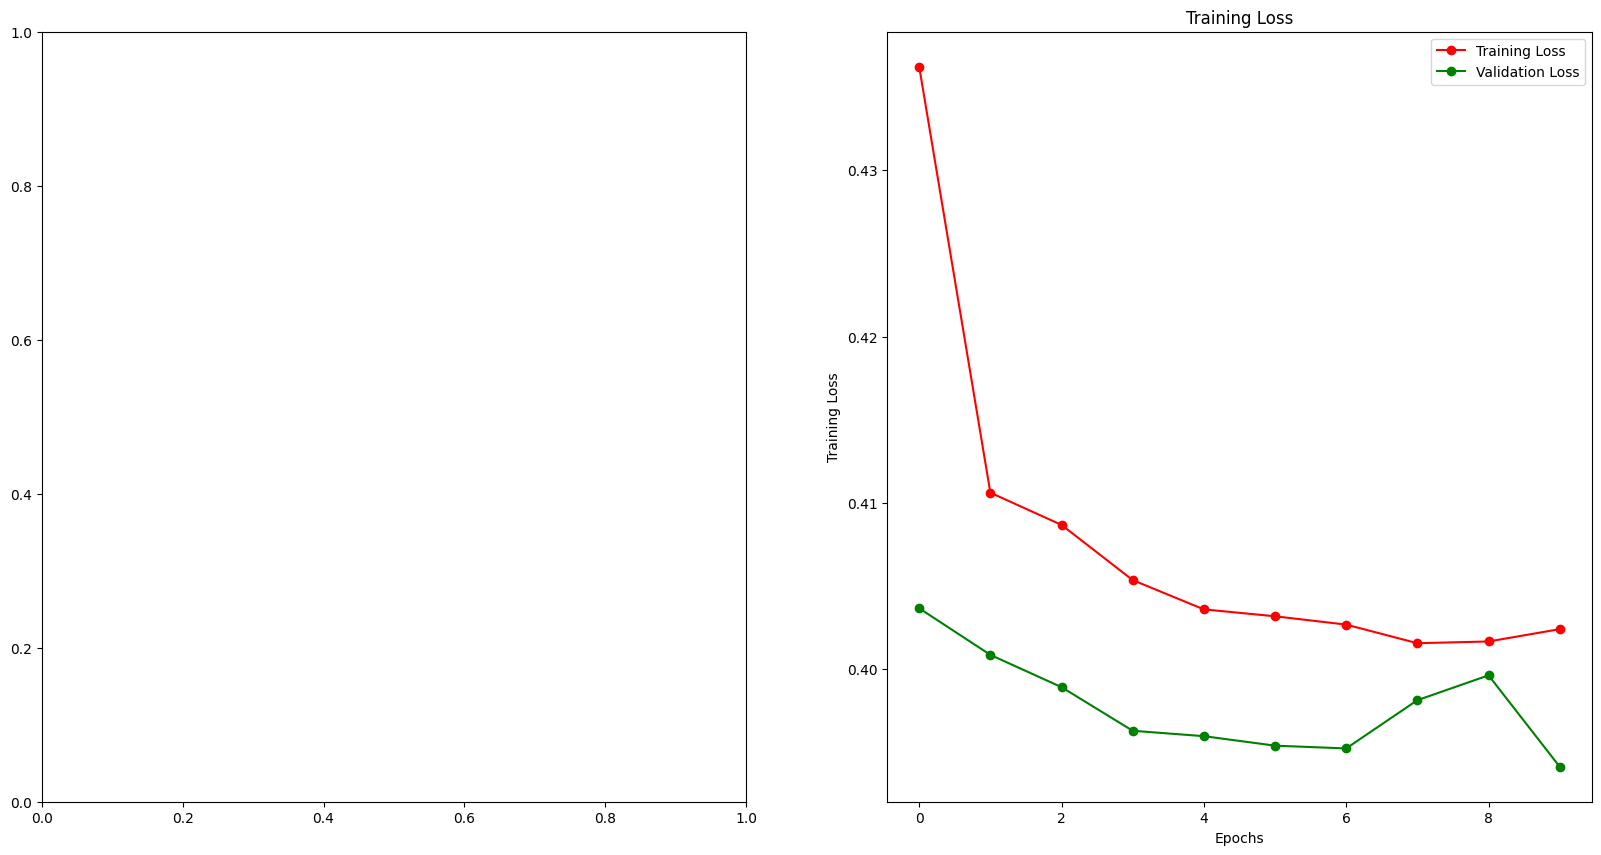

In [56]:
epochs = list(range(len(history.history['loss'])))
fig , ax = plt.subplots(1,2)

train_loss = history.history['loss']

val_loss = history.history['val_loss']

fig.set_size_inches(20,10)



ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

In [57]:
autoencoder.save("auto_encoder.h5")
encoder.save('encoder.h5')
decoder.save('decoder.h5')

In [69]:
import cv2

image_path = "new_garbage_classification/cardboard/cardboard1.jpg"
img = cv2.imread("image_path")
img


In [70]:
orig = cv2.imread(test.iloc[0]['Image']) 
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
orig=orig* 1.0 / 255.0
orig = cv2.resize(orig, (size, size),
               interpolation = cv2.INTER_NEAREST)
img = tf.expand_dims(orig, axis=0)

encoder_output=encoder.predict(img)
plt.title('Original')
plt.imshow(orig)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
data_directory = "new_garbage_classification/"